In [ ]:
# New to Jupyter notebook? Check out the Jupyter notebook 
# documentation (https://jupyter-notebook.readthedocs.io/en/stable/ui_components.html), 
# and try the User interface tour in the Help menu above.
%pip install matplotlib

# BlockSci Setup

In [2]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

In [3]:
# parser_data_directory should be set to the data-directory which the blocksci_parser output
chain = blocksci.Blockchain(str(parser_data_directory))

# Measuring different types of address use

In [ ]:
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value(), cpu_count=64)

In [ ]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot()
ax.set_ylim(ymin=0)

# Visualizing Transaction Fees for an individual block

In [ ]:
example_block_height = 465100
df = pd.DataFrame(chain[example_block_height].txes.fee_per_byte(), columns=["Satoshis per byte"])
ax = df.reset_index().plot.scatter(x="index", y="Satoshis per byte")
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

# Identifying Overlay Applications

In [15]:
%time txes = chain.blocks.txes.including_output_of_type(blocksci.address_type.nulldata)

CPU times: user 475 µs, sys: 0 ns, total: 475 µs
Wall time: 489 µs


In [ ]:
%time labels = [(tx.block.time, blocksci.label_application(tx)) for tx in txes]

In [16]:
%time labels = chain.map_blocks(lambda block: [(tx.block.time, blocksci.label_application(tx)) for tx in block.txes], cpu_count=96)


CPU times: user 5min 24s, sys: 28min 7s, total: 33min 32s
Wall time: 40min 5s


In [17]:
nl = []
for i in labels:
    nl += i

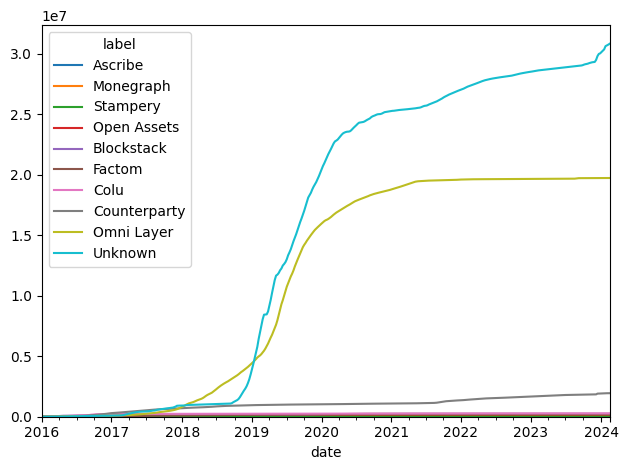

In [18]:
df = pd.DataFrame(nl, columns=["date", "label"])
df = df.reset_index().groupby(["date", "label"]).count().unstack(level=-1).fillna(0)
df.columns = df.columns.droplevel()
important_columns = list(df[df.index > pd.to_datetime("1-1-2016")].sum().sort_values()[-10:].index)
important_columns = [x for x in important_columns if "Address" not in x]
ax = df[df.index > pd.to_datetime("1-1-2016")].cumsum().resample("w").mean()[important_columns].plot()
ax.set_ylim(0)
plt.tight_layout()

# Average Fee per Transaction in 2017 in USD

In [ ]:
converter = blocksci.CurrencyConverter()

In [ ]:
# BlockSci vectorized interface
blocks = chain.range('2017')
fees = blocks.fee / blocks.tx_count
times = blocks.time

In [ ]:
df = pd.DataFrame({"Fee":fees}, index=times)
df = converter.satoshi_to_currency_df(df, chain)
ax = df.resample("d").mean().plot(legend=False)
ax.set_ylim(ymin=0)
plt.tight_layout()

# Transactions Paying over 1000 dollars in fees

In [ ]:
%time high_fee_txes = [(tx.block.height, tx.fee) for tx in chain.blocks.txes.where(lambda tx: tx.fee > 10**7)]

In [ ]:
converter = blocksci.CurrencyConverter()
print(converter.data)

In [ ]:
df = pd.DataFrame(high_fee_txes, columns=["height", "fee"])
df.index = df["height"]
df["fee"] = df.apply(lambda x: converter.satoshi_to_currency(x["fee"], chain[x["height"]].time) if chain[x["height"]].time > datetime.datetime.fromisoformat('2013-10-01') else 0, axis=1)
df = df[df["fee"] > 1000]
df = chain.heights_to_dates(df)
fig, ax = plt.subplots()
ax.plot_date(df.index, df["fee"], fmt="x")
ax.set_yscale("log")
formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

# Balance held by cluster

In [ ]:
cm = blocksci.cluster.ClusterManager.create_clustering("/mnt/anal/cluster", chain)


In [ ]:
# cluster_data_directory should be set to the directory containing the
# output of the `clusterer` program
cm = blocksci.cluster.ClusterManager("/mnt/anal/cluster", chain)

In [ ]:
# Find the balance held by the cluster containing the given address at block height 494653 
# txid = chain.tx_with_hash("d31c2b4d71eb143b23bb87919dda7fdfecee337ffa1468d1c431ece37698f918")
# cluster = cm.cluster_with_address(txid.)
address = chain.address_from_string("3EhLZarJUNSfV6TWMZY1Nh5mi3FMsdHa5U")
cluster = cm.cluster_with_address(address)
sum(address.balance(494653) for address in cluster.addresses.to_list()) / 1e8

In [ ]:
from blocksci import heuristics


possible_coinjoins = chain.range(start="2022-06-17", end="2022-06-19").txes.where(lambda tx: heuristics.is_coinjoin(tx)).to_list()

In [ ]:
for cluster in cm.clusters():
    for address in cluster.addresses.to_list():
        print(address.address_string)


In [ ]:
for tx in possible_coinjoins:
    if tx.input_count > 50 and tx.input_count < 80:
        print(tx.block_height, tx.input_count, tx.hash)

# Parsing dumplings

In [5]:
import json

wasabi2_events_file = dumplings_directory / "wasabi2_events.json"
wasabi2_txs_file = dumplings_directory / "wasabi2_txs.json"
wasabi_events_file = dumplings_directory / "wasabi_events.json"
wasabi_txs_file = dumplings_directory / "wasabi_txs.json"
whirlpool_events_file = dumplings_directory / "whirlpool_events.json"
whirlpool_txs_file = dumplings_directory / "whirlpool_txs.json"

with open(wasabi2_events_file) as f:
    wasabi2_events = json.load(f)

with open(wasabi2_txs_file) as f:
    wasabi2_txs = json.load(f)

for i in wasabi2_events:
    print(i)
    print(wasabi2_events[i])
    txid = i
    break
    
print("coinjoin inputs:")

0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc
{'txid': '0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc', 'block_index': 1683, 'broadcast_time': '2023-06-26 12:15:11.000', 'inputs': {'63': {'value': 9653620, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '64': {'value': 9598093, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '65': {'value': 9597044, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '66': {'value': 9518520, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '80': {'value': 3910526, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}}, 'outputs': {'27': {'value': 50000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '29': {'value': 33554432, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '31': {'value': 33554432, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '33': {'value': 33554432, 'wallet_name': 'real_unknown', 'mix

In [6]:
with open(wasabi_events_file) as f:
    wasabi_events = json.load(f)

with open(wasabi_txs_file) as f:
    wasabi_txs = json.load(f)

for i in wasabi_events:
    print(i)
    print(wasabi_events[i])
    txid = i
    break
    
print("coinjoin inputs:")

00009dd9971635815b2c4f86647b6e462922724df5e10f3893b5812df87fb907
{'txid': '00009dd9971635815b2c4f86647b6e462922724df5e10f3893b5812df87fb907', 'block_index': 1235, 'broadcast_time': '2020-10-03 02:59:11.000', 'inputs': {'46': {'value': 28096790, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '47': {'value': 28925390, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '54': {'value': 2762675090, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}}, 'outputs': {'0': {'value': 43932, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '2': {'value': 68610, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '3': {'value': 78983, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '5': {'value': 148760, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '7': {'value': 209765, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '10': {'value': 643064, 'wallet_name': 'real_unknown', 'mix_event_type':

In [5]:
print(len(wasabi_txs["coinjoins"][str(txid)]["inputs"]))

196


In [7]:
with open(whirlpool_events_file) as f:
    whirlpool_events = json.load(f)

with open(whirlpool_txs_file) as f:
    whirlpool_txs = json.load(f)

for i in whirlpool_events:
    print(i)
    print(whirlpool_events[i])
    txid = i
    break
    
print("coinjoin inputs:")

print(whirlpool_txs["coinjoins"][str(txid)]["inputs"])

0000208d62b74f91f44b9397bed22a91b3ec944344a6ea8b8e811cf2dfff3a28
{'txid': '0000208d62b74f91f44b9397bed22a91b3ec944344a6ea8b8e811cf2dfff3a28', 'block_index': 1527, 'broadcast_time': '2020-08-14 07:14:38.000', 'inputs': {'2': {'value': 5003932, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}, '4': {'value': 5007562, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_ENTER'}}, 'outputs': {'0': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '1': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '2': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}}, 'num_inputs': 5, 'num_outputs': 5}
coinjoin inputs:


NameError: name 'tx' is not defined

In [14]:
new_txid = next(filter(lambda x: len(x["inputs"]) <= 6, wasabi_events.values()))["txid"]
print(f"number of wasabi inputs: {len(wasabi_events[new_txid]['inputs'])}")
# 
tx = chain.tx_with_hash(new_txid)

print(f"TX: {tx} with id {tx.hash}")
print(f"Available on tx: {dir(tx)}")
print()
print("Block/info")
print(f"Tx block: {tx.block}, block height: {tx.block_height}, block time: {tx.block_time}")
print(f"OP: {tx.op_return}, input count: {tx.input_count}, output count: {tx.output_count}")
print()
print()

print("In txes:")
# for in_tx in tx.inputs:
#     print(in_tx)

print(f"Input value: {sum(x.value for x in tx.inputs)}")

print()
print("Out txes:")
# for out_tx in tx.outputs:
#     print(out_tx)
    
print(f"Output value: {sum(x.value for x in tx.outputs)}")
print(f"Fee: {tx.fee}")


number of wasabi inputs: 5
TX: Tx(len(txins)=196, len(txouts)=171, size_bytes=18749, block_height=796000, tx_index=856691436) with id 0002eb55bd780c4fc10f212bb686a0a9426ef11d611827605ba8f82db30bcbbc
Available on tx: ['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_access', '_self_proxy', 'base_size', 'block', 'block_height', 'block_time', 'fee', 'fee_per_byte', 'fee_per_kbyte', 'hash', 'includes_output_of_type', 'index', 'input_count', 'input_value', 'inputs', 'ins', 'is_coinbase', 'locktime', 'observed_in_mempool', 'op_return', 'output_count', 'output_value', 'outputs', 'outs', 'size_bytes', 'time_seen', 'timestamp_seen', 'total_size', 'version', 'virtual_size', 'weight']

Block/info
Tx block: Block(tx_count=2457, heig

In [99]:
next_within_hop = {"gone": 0, "same": 0, "different": 0, "correct": 0, "total": 0, "done": 0}
events = whirlpool_txs["coinjoins"]

def get_cj_type_from_events(events, tx_hash, index):
    return events[tx_hash]["outputs"][str(index)]["mix_event_type"]
#     return events[tx_hash]["outputs"].get(str(index), {}).get("mix_event_type", None)
    


count = 0
for i in events:
    next_within_hop["total"] += 1
    txid = i
    try:
        tx_on_blockchain = chain.tx_with_hash(txid)
    except RuntimeError as e:
        pass
#     print(tx_on_blockchain.output_count)
    
    next_within_hop["done"] += 1
    for next_tx in tx_on_blockchain.outputs:
        if not next_tx.is_spent:
            continue
            
        next_spending_tx = next_tx.spending_tx
        cj_type = get_cj_type_from_events(events, txid, next_tx.index)
        if next_spending_tx.hash in events:
            next_within_hop["same"] += 1
            if cj_type == "MIX_REMIX":
                next_within_hop["correct"] += 1
        elif next_spending_tx.hash in wasabi2_events or next_spending_tx.hash in wasabi_events:
            next_within_hop["different"] += 1
            if cj_type is None:
                next_within_hop["correct"] += 1
        else:
            if cj_type == "MIX_LEAVE" or cj_type is None:
                next_within_hop["correct"] += 1
            next_within_hop["gone"] += 1
    
next_within_hop

{'gone': 2639038,
 'same': 0,
 'different': 0,
 'correct': 936915,
 'total': 524075,
 'done': 524075}

In [64]:
curr = next(iter(events))

print(events[curr]["outputs"])

sadf = chain.tx_with_hash(curr).outputs
for i in sadf:
    print(i.index)

{'0': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '1': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}, '2': {'value': 5000000, 'wallet_name': 'real_unknown', 'mix_event_type': 'MIX_LEAVE'}}
0
1
2
3
4


In [96]:
for tx in wasabi2_txs["coinjoins"].values():
    for out in tx["outputs"].values():
        if out["mix_event_type"] != "MIX_LEAVE" and out["mix_event_type"] != "MIX_ENTER":
            print(out)
            break
    break


          

{'value': 20000000, 'wallet_name': 'real_unknown', 'address': '001474130481f563411af0e8576bd6488f60fbc68d9d', 'script_type': 'TxWitnessV0Keyhash', 'spend_by_tx': 'vin_31461f8bfdeb5a7c08f4e0d81385c27b6c487fd658704b57fa99a735411acf86_4', 'mix_event_type': 'MIX_REMIX'}


In [45]:
for in_tx in txid.inputs:
    print(in_tx)
    
print()

for out_tx in txid.outputs:
    print(out_tx)
    

In [ ]:
# 3 hops away - consolidation
# how many in how many remix how many out
# 1 - 2 hops

In [125]:
from multiprocessing import Pool

def init_worker(shared_data_arg):
    global shared_data
    events2 = shared_data_arg

def map_function(tx_hash):
    chain = blocksci.Blockchain(str(parser_data_directory))
    tx = chain.tx_with_hash(tx_hash)
    results = []
    print("before for", tx_hash, events2.keys())
    for output in tx.outputs:
        if not output.is_spent:
            continue

        # First hop
        print("first hop", tx_hash, output.hash)
        spending_tx = output.spending_tx
        mix_event_type = get_cj_type_from_events(events2, spending_tx.hash, output.index)

        if mix_event_type == "MIX_REMIX":
            results.append((tx_hash, spending_tx.hash, "remix"))
        elif mix_event_type == "MIX_LEAVE":
            results.append((tx_hash, spending_tx.hash, "left"))

        # Second hop - iterate through outputs of the spending_tx
        for second_output in spending_tx.outputs:
            if not second_output.is_spent:
                continue

            second_spending_tx = second_output.spending_tx
            second_mix_event_type = get_cj_type_from_events(events2, second_spending_tx.hash, second_output.index)

            if second_mix_event_type == "MIX_REMIX":
                results.append((spending_tx.hash, second_spending_tx.hash, "remix"))
            elif second_mix_event_type == "MIX_LEAVE":
                results.append((spending_tx.hash, second_spending_tx.hash, "left"))

    return results


In [ ]:
from multiprocessing import Pool

coinjoin_tx_hashes = list(wasabi2_txs["coinjoins"].keys())  # Assuming dict keys are tx hashes

with Pool(64, initializer=init_worker, initargs=(events,)) as pool:  # Adjust number of processes according to your system
    all_results_future = pool.map_async(map_function, coinjoin_tx_hashes)
    print("in get")
    all_results = all_results.get()


in get


In [ ]:
def mapper(block: blocksci.Block):
    for tx in block.txes:
        results = []

        for output in tx.outputs:
            if not output.is_spent:
                continue

            # First hop
            spending_tx = output.spending_tx
            mix_event_type = get_cj_type_from_events(events, spending_tx.hash, output.index)

            if mix_event_type == "MIX_REMIX":
                results.append((tx_hash, spending_tx.hash, "remix"))
            elif mix_event_type == "MIX_LEAVE":
                results.append((tx_hash, spending_tx.hash, "left"))

            # Second hop - iterate through outputs of the spending_tx
            for second_output in spending_tx.outputs:
                if not second_output.is_spent:
                    continue

                second_spending_tx = second_output.spending_tx
                second_mix_event_type = get_cj_type_from_events(events, second_spending_tx.hash, second_output.index)

                if second_mix_event_type == "MIX_REMIX":
                    results.append((spending_tx.hash, second_spending_tx.hash, "remix"))
                elif second_mix_event_type == "MIX_LEAVE":
                    results.append((spending_tx.hash, second_spending_tx.hash, "left"))

    return results